# Random Forest for Optimal Character Recognition

Here, we build a random forest to classify between two handwritten numbers, 3 and 5. The data set used is from Oregon State University, Fall 2018 CS 534 Machine Learning Course Implementation Assignment 3.

There are 100 features for each sample, corresponding to the top 100 principal components generated using PCA from the original sample features of size 28 * 28.

The training set contains 4888 samples. Each sample is a list of 101 values. The first column represents the digit’s label which is 3 or 5. The other 100 floating values are the PCA-generated features for this sample.

The test set contains 1629 samples.

# Import Libraries

In [34]:
import copy
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Preprocessing

In [35]:
class Preprocessing:
    
    def __init__(self, raw_training_data_path, raw_validation_data_path):
            
            # Read the training and validation data. As the features are just PCA components, no need to observe the 
            # column names, so can proceed with numpy instead of pandas.
            
            self.raw_training_data = np.genfromtxt(raw_training_data_path, delimiter = ",")
            self.raw_validation_data = np.genfromtxt(raw_validation_data_path, delimiter = ",")
            
            print(self.raw_training_data[0:10,:])
            
            # split training features and labels
            self.training_features = self.raw_training_data[:, 1:]
            self.training_labels = self.raw_training_data[:, 0]
            
            print("No of training samples: {}, No of training features: {}".format(len(self.training_labels), self.training_features.shape[1]))
            
            
            # split validation features and labels
            self.validation_features = self.raw_validation_data[:, 1:]
            self.validation_labels = self.raw_validation_data[:, 0]
            
            print("No of validation samples: {}".format(len(self.validation_labels), ))

     

# Decision Tree Implementation
This decision tree will facilitate the random forest algorithm later.

In [46]:
class Decision_Tree_Node:
    
    def __init__(self, X = None, y = None, depth = None):
        self.X = X
        self.y = y

        self.left = None
        self.right = None
        self.depth = depth
        self.feature_index_with_optimal_split = None
        self.threshold_for_optimal_split = None # since features are real values
        self.is_leaf = False
        self.class_probabilities = None


class Decision_Tree(BaseEstimator, ClassifierMixin):
    
    '''
    Implementation of CART Decision Tree.
    
    Parameters
    -------------
    max_depth : int, optional, default 100
                The maximum depth of the deicison tree for early-stopping/ to avoid overfitting to outliers.
    min_pool :  int, optional, default 10
                The minimum number of samples at a node after split for early-stopping/ to avoid overfitting.
    '''
    
    
    
    def __init__(self, root, max_depth = None, min_pool = None, no_of_bagging_features = 10):
        
        self.root = root
        self.max_depth = max_depth
        self.min_samples = min_pool
        self.classes = None
        self.no_of_bagging_features = no_of_bagging_features
        
        
        
    
    
    def build_decision_tree(self, X, y, node, current_depth):

        '''
        Recursively builds the decision tree if the terminal conditions not met
        
        Parameters
        -----------------
        X : training features
        y : training labels
        ''' 
        
        # base cases of recursion
        if current_depth >= self.max_depth:
            node.is_leaf = True
            
            
        elif len(y) <= self.min_samples:
            node.is_leaf = True
            
        
        elif len(np.unique(y)) == 1:
            node.is_leaf = True
        
        else:
            
            
            
            # find the best split and the feature that gives this best split
            feature_for_best_split, best_split_threshold, X_left, X_right, y_left, y_right = self.best_split(X, y)#, node.depth) 
            
            
            if feature_for_best_split is None:
                # best_split() returns None if no feature gave a split that has less impurity than the parent
                node.is_leaf = True
                
            else:
                
                # Recursively build trees to the left and the right using the best features and the best split threshold
                node.depth = current_depth
                node.feature_index_with_optimal_split = feature_for_best_split
                node.threshold_for_optimal_split = best_split_threshold
                
                node.left = Decision_Tree_Node(X_left, y_left, current_depth+1)
                node.right = Decision_Tree_Node(X_right, y_right, current_depth+1)
                
                # when a node is encountered, calculate the class probabilities for each class at this node and store
                node.left.class_probabilities = self.calculate_class_probabilities(y_left)
                node.right.class_probabilities = self.calculate_class_probabilities(y_right)
                
                self.build_decision_tree(X_left, y_left, node.left, current_depth+1)
                self.build_decision_tree(X_right, y_right, node.right, current_depth+1)
            
        
    
        
    def gini_data(self,y): #####################MAKE THIS EFFICEINT
        '''
        Calculates the GINI impurity of y before split.
        '''
        #count the Y equal to one
        c_root_pos=np.count_nonzero(y==3) # The labels are 3 and 5, 3 is the first label in ascending order.
        c_root_total = len(y)        
        
        gini_of_y =  1- (c_root_pos/c_root_total)**2 -((c_root_total-c_root_pos)/c_root_total)**2 
        return gini_of_y
  

    def gini_after_split(self, y_copy, indices_where_change, i):
        
        '''
        Calculates GINI impurity metric U after split of y_copy.
        
        U = (p^2) + (q^2 )
        
        where p = No of samples at this node with feature x below the node threshold/ No of samples at this node
              q = No of samples at this node with feature x equal or above the node threshold/ No of samples at this node
        
        Parameters
        -----------------
        '''
        
        CL_pos = np.count_nonzero(y_copy[:indices_where_change[i] + 1] == 3)
        CL_total = len(y_copy[:indices_where_change[i] + 1])
        CL_neg = CL_total - CL_pos
        prob1 = CL_pos / (CL_total)
        prob2 = CL_neg / (CL_total)
        UAL = 1 - (prob1) ** 2 - (prob2) ** 2



        CR_pos = np.count_nonzero(y_copy[indices_where_change[i] + 1:] == 3)
        CR_total = len(y_copy[indices_where_change[i] + 1:])
        CR_neg = CR_total - CR_pos
        prob1 = CR_pos / (CR_total)
        prob2 = CR_neg / (CR_total)
        UAR = 1 - (prob1) ** 2 - (prob2) ** 2


        pl = (CL_total) / len(y_copy)
        pr = (CR_total) / len(y_copy)
        
        gini_after_split =  pl * UAL + pr * UAR
        
        return gini_after_split
    
    
    
    
    def split_node(self, X, y, best_feature, max_benefit_val):
        '''
        Splits a node using the best feature that maximizes Information Gain.
        '''
        left_X, right_X, left_y, right_y = [],[],[],[]

        for row in range(0,X.shape[0]):
            if X[row][best_feature] < max_benefit_val:
                left_X.append(X[row])
                left_y.append(y[row])
            else:
                right_X.append(X[row])
                right_y.append(y[row])
        
        return np.array(left_X), np.array(right_X), np.array(left_y), np.array(right_y)
        
        
        
        
    def bag_features(self, X):
        '''
        Generates the indices of the features to select to make splitting decisions.
        '''
        no_of_features = len(X[0])
        
        features_to_select_set = set()
        features_to_select_list = []
        
        while len(features_to_select_list) < self.no_of_bagging_features:
            
            feature_selected = random.randint(0, no_of_features-1)
            if feature_selected not in features_to_select_set:
                features_to_select_list.append(feature_selected)
        
        return features_to_select_list
            
        
        
    def best_split(self, X_passed, y_passed):
        '''
        Divides the training samples into optimal splits according to the impurity metric
        '''
        numpy_X = []
        numpy_y = []
        
        
        
        
        for row in range(0,len(X_passed)):
            numpy_X.append(X_passed[row])
            numpy_y.append(y_passed[row])
        
        X = np.array(numpy_X)
        y = np.array(numpy_y)
        
        
        gini_before_split = self.gini_data(y)

        benefit_of_split = 0
        
        benefit_vals_for_one_feature = np.zeros(X.shape[1])
        max_benefit_index_for_each_feature = np.zeros(X.shape[1])

        
        # FEATURE BAGGING
        feature_indices_to_bag = self.bag_features(X)
        
               
        # for each bagged feature, find the GINI gain at each threshold
        for feature in range(0,len(feature_indices_to_bag)):
            
            current_feature = X[:, feature_indices_to_bag[feature]]
            
            # TRICK: Sort the training samples according to this feature's values
            # and find GINI only at samples where the class label changes.
            
            
            stacked = np.column_stack((y, current_feature)) # stack y_to_take and current_feature
            sortedd = stacked[np.argsort(stacked[:, 1])]
            
            y_copy = sortedd[..., 0]
            #indices_where_change = np.where(np.roll(y_copy,1)!=y_copy)[0]

            indices_where_change = np.where(y_copy[:-1] != y_copy[1:])[0]
            
            # the values in indices_where_change are the indices after which the label changes.
                                            
            for i in range(len(indices_where_change)):

                gini_after_split = self.gini_after_split(y_copy, indices_where_change, i)

                benefit_of_split = gini_before_split - gini_after_split


                if benefit_of_split >  benefit_vals_for_one_feature[feature]:
                    benefit_vals_for_one_feature[feature] = benefit_of_split  
                    max_benefit_index_for_each_feature[feature] = indices_where_change[i]
                   
                
                    

        if benefit_of_split == 0:
            #print("No good feature found.")
            return None, None, None, None, None, None
        else:
            
            best_feature = np.argmax(benefit_vals_for_one_feature)
            index_of_threhold_with_max_benefit_for_best_feature = max_benefit_index_for_each_feature[best_feature]
            
            # lets get the column of that feature and sort and get the threshold
            max_benefit_feature = copy.deepcopy(X[:,best_feature])
            max_benefit_feature.sort()
            
            # Athough we have threshold_index_for_best_split_in_indices_where_change, we need to find the
            # corresponding index in the sorted max benefit feature.
            

            max_benefit_val = max_benefit_feature[int(index_of_threhold_with_max_benefit_for_best_feature)+1]
            
            
            X_left, X_right, y_left, y_right = self.split_node(X, y, best_feature, max_benefit_val)
            
                        
            # feature_for_best_split, best_split_threshold, X_left, X_right, y_left, y_right
            return best_feature, max_benefit_val, X_left, X_right, y_left, y_right
                
                        

                
    def calculate_class_probabilities(self, y):
        '''
        Calculates the probability of each class at this node
        '''
        
        class_probabilities = []
        
        for label in self.root.classes:
            
            if len(y[y==label]) == len(y) :
                class_prob = 1
            elif len(y[y==label]) == 0:
                class_prob = 0
            else:
                class_prob = y[y==label].shape[0]/len(y)
            
            class_probabilities.append(class_prob)
        
        return class_probabilities
    
         
            
    
    def predict_a_sample(self, x, node):
        '''
        Predicts a class label for the passed test sample by recursively calling a child node from the root upto
        a leaf node of the learned decision tree.
        
        Parameters
        ------------------
        x : a single test sample features
        node : a node of the learned decision tree
        '''
        
        if node.is_leaf:
            return node.class_probabilities
        else:
            
            if x[node.feature_index_with_optimal_split] < node.threshold_for_optimal_split:
                return self.predict_a_sample(x, node.left)
            else:
                return self.predict_a_sample(x, node.right)
    
    
    
    def predict(self, X):
        '''
        Predicts class labels for all test samples passed.
        
        Parameters
        ---------------------------
        X : test samples passed as 2D arrays
        '''        
        test_preds = []
        for test_sample in X:
            class_probabilities = self.predict_a_sample(test_sample, self.root)
            test_pred = np.argmax(class_probabilities)
            if test_pred == 0:
                
                test_preds.append(3)
            elif test_pred == 1:
                test_preds.append(5)
            else:
                raise AssertionError
        
        return test_preds
        
       
    
    def fit(self, X, y):
        
        '''
        Train CART decision tree using GINI impurity.
        
        Parameters
        ----------------
        X : arraylike
            The training samples in 2D format, corresponding to input features of each sample.
        y : arraylike, optional, default None
            The labels for each sample in X. Some algorithms do not require the label y while some (like Decisoin Tree) do.
            Hence, keep y as optional.
        
        Returns
        ----------------
        self : Trained Decision Tree object
               This method returns self for compatibility reasons with sklearn's other interfaces/ functionalities.
        
        
        '''
        self.root = Decision_Tree_Node(X, y, 0)
        self.root.classes = list(set(y)) # gives the set of unique elements in y.
        self.root.classes.sort() # sorts in ascending order in-place if not already sorted
        #print("The unique classes present in training data:{}".format(self.root.classes))
        self.build_decision_tree(X = X, y = y, node = self.root, current_depth = 0)

# Random Forest Implementation

In [47]:
class Random_Forest:
    
    def __init__(self, train_X, train_y, test_X, test_y, max_depth, min_pool, num_of_trees, subsample_size, num_of_features_for_bagging):
        '''
        Initializes the parameters of the random forest.
        '''
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
        
        self.unique_classes = np.unique(self.train_y)
        
        self.max_depth = max_depth
        self.min_pool = min_pool
        
        self.num_of_trees = num_of_trees
        self.subsample_size = subsample_size
        self.num_of_features_for_bagging = num_of_features_for_bagging
        
        self.trees = []
    

    def subsample_training_data(self):
        '''
        Generates a subsample of size self.sample_size from the training data.
        '''
        
        training_X_subsample = []
        training_y_subsample = []
        
        for row in range(0, int(self.subsample_size)):
            index = random.randint(0, len(self.train_y)-1)
            
            training_X_subsample.append(self.train_X[index])
            training_y_subsample.append(self.train_y[index])
        
        X = np.array(training_X_subsample)
        y = np.array(training_y_subsample)
        
        return X,y
        
    
    
    def bagging_vote(self, sample):
        '''
        Predicts a class label for a sample. The prediction is the class label that has the maximum number of votes 
        from the different trees in the random forest.
        '''
        classes = dict()
        for class_ in self.unique_classes:
            classes[int(class_)] = 0
        
        for tree in self.trees:
            prediction  = tree.predict([sample])[0] #unsqueeze using [0]
            classes[prediction] += 1
        
        major_class = None
        major_class_vote = 0
        
        for class_key in classes:
            class_val = classes[class_key]
            if class_val > major_class_vote:
                major_class = class_key
                major_class_vote = class_val
        
        return major_class
                
    
    
    def predict_a_sample(self, features):
        '''
        Predicts a class label for a sample.
        '''
        prediction = self.bagging_vote(features)
        return prediction
    
    
    
    def predict(self, features):
        '''
        Predicts class label a set of samples.
        '''
        predictions = []
        for idx in range(len(features)):
            predictions.append(self.predict_a_sample(features[idx]))
        
        return predictions
                
        
    

    def train_decision_tree(self, X, y, max_depth, min_pool):
        '''
        Creates and trains a decision tree of the random forest based on the data set and parameters passed.
        '''
        root_node = Decision_Tree_Node(X,y,max_depth)
        
        decision_tree = Decision_Tree(root_node, max_depth, min_pool, self.num_of_features_for_bagging)

        decision_tree.fit(X, y)
        
        return decision_tree
    
    

    def fit(self):
        '''
        Trains all decision trees of the random forest.
        '''
        
        
        for tree_num in range(0, self.num_of_trees):
            
            subsample_X, subsample_y = self.subsample_training_data()
            
            
            tree = self.train_decision_tree(X = subsample_X, y = subsample_y, max_depth = self.max_depth, min_pool = self.min_pool)
            self.trees.append(tree)
        


## Train

In [48]:
# read data
training_data_path = "data/pa3_train_reduced.csv"
validation_data_path = "data/pa3_valid_reduced.csv"

preprocessing = Preprocessing(training_data_path, validation_data_path)

[[   5.     -252.5092 1040.6188 ...  -21.6094  -32.602    25.619 ]
 [   5.     -684.5502 -368.7191 ...  -36.3467   26.6937  -17.564 ]
 [   3.      119.2934  638.9885 ...   14.7913   48.7926  -94.5664]
 ...
 [   5.      972.0162   77.9232 ...  -35.5166  -16.6162  -43.1298]
 [   5.     -255.5209  144.6523 ...   75.572    34.6369   24.2973]
 [   3.      217.1434  592.4619 ...  -25.7318   55.1806    4.9309]]
No of training samples: 4888, No of training features: 100
No of validation samples: 1629


In [59]:
max_depth = 15
min_pool = 1

total_training_samples = len(preprocessing.training_labels)
sample_size_for_bagging = total_training_samples
total_features_len = len(preprocessing.training_features[0])
num_of_features_for_bagging = total_features_len/5


num_trees_for_random_forest = [1,2,5, 10, 25]

In [60]:
training_accuracy = []
test_accuracy = []

for num_trees in num_trees_for_random_forest:

    random_forest = Random_Forest(preprocessing.training_features,
                                  preprocessing.training_labels,
                                  preprocessing.validation_features,
                                  preprocessing.validation_labels,
                                  max_depth,
                                  min_pool,
                                  num_trees,
                                  sample_size_for_bagging,
                                  num_of_features_for_bagging

                                 )
    random_forest.fit()
    
    # predict for both training data and test data
    training_predictions = random_forest.predict(preprocessing.training_features)
    training_accuracy.append(accuracy_score(preprocessing.training_labels, training_predictions))
    
    
    test_predictions = random_forest.predict(preprocessing.validation_features)
    test_accuracy.append(accuracy_score(preprocessing.validation_labels, test_predictions))
    
    
    
    

# Plot the Results

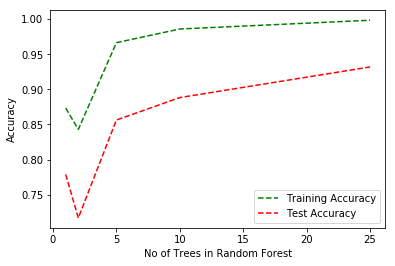

In [61]:
plt.plot(num_trees_for_random_forest, training_accuracy, 'g--', label="Training Accuracy")
plt.plot(num_trees_for_random_forest, test_accuracy, 'r--', label="Test Accuracy")
plt.xlabel("No of Trees in Random Forest")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
